# Client/User A, Bob
In this jupyter notebook, we simulate how User A obtains the base_model from the server. After obtaining the base_model, User A trains the model on his data. Then,  weights were extracted from the Dense layer. These weights are encrypted, serialized and stored in a pickle file to send to the server. After getting the updated model from the server, User A check the new model's accuracy.

#### Import Libraries

In [58]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import tenseal as ts
import pickle
from fractions import Fraction

## Creating User A's dataset. 
User A dataset consists of only digits 0 to 4 from the MNIST dataset. The dataset is split into 3 main parts: Server data, User A data and User B data.  
In this section, User's A data is made to contain only digits 0 to 4.

In [59]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [60]:
# Slicing the MNIST original dataset to retain only part of the dataset.
x_train = x_train[20000:40596,:,:]
y_train = y_train[20000:40596]
x_test = x_test[4000:7139,:,:]
y_test  = y_test[4000:7139]

In [61]:
# Length of the new dataset
print("x_train:", len(x_train))
print("y_train:", len(y_train))
print("x_test:", len(x_test))
print("y_test:", len(y_test))

x_train: 20596
y_train: 20596
x_test: 3139
y_test: 3139


In [62]:
# Filter the new dataset to retain only digits 0 to 4.
def filter_01234(x, y):
    keep = (y == 0) | (y == 1) | (y == 2)| (y == 3) | (y == 4)
    x, y = x[keep], y[keep]
    return x,y

In [63]:
# Filtered dataset
x_train, y_train = filter_01234(x_train, y_train)
x_test, y_test = filter_01234(x_test, y_test)
print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 10509
Number of filtered test examples: 1603


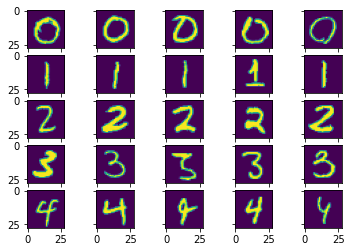

In [64]:
# Display a sample of the User A's dataset. 
digits = {}
for i in range(5):
    digits[i] = np.where(y_test==i)[0][:5]
#print(digits)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(x_test[digits[i][j]])

## Getting the base model.  
In this section, we retrieve the base_model and train it on User A's data.

In [65]:
# Retrieving the base model.
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture.
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7840      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                100       
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Creating a multiclass confusion matrix before training.
predictions = new_model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

array([[303,   0,   1,   0,   0,   3,   4,   1,   1,   0],
       [  0, 349,   2,   2,   0,   1,   1,   0,   3,   0],
       [  1,   3, 299,   5,   1,   3,   6,   2,   6,   0],
       [  1,   2,  10, 272,   0,  15,   0,   5,   4,   0],
       [  2,   1,   1,   0, 277,   1,   2,   1,   3,   9],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

In [67]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy before training.
new_model.evaluate(x_test, y_test)

51/51 [==============================] - 0s 1ms/step - loss: 0.3041 - sparse_categorical_accuracy: 0.9357


e:\UDM\M2_privacyinAI\code_final\venv\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


[0.30413129925727844, 0.9357454776763916]

In [68]:
# Compiling the model.
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [69]:
# Retraining the base_model to obtain the new weights.
new_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/100
83/83 [==============================] - 1s 3ms/step - loss: 0.4545 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.1834 - val_sparse_categorical_accuracy: 0.9607
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.3508 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.1481 - val_sparse_categorical_accuracy: 0.9669
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.3187 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.1311 - val_sparse_categorical_accuracy: 0.9707
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.2781 - sparse_categorical_accuracy: 0.9207 - val_loss: 0.1189 - val_sparse_categorical_accuracy: 0.9707
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.2655 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.1071 - val_sparse_categorical_accuracy: 0.9719
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.2334 - sparse_categorical_accu

In [70]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy after training.
new_model.evaluate(x_test, y_test)

51/51 [==============================] - 0s 1ms/step - loss: 0.0926 - sparse_categorical_accuracy: 0.9788


[0.09257857501506805, 0.978789746761322]

## Extracting weights & bias.

In [71]:
# Checking which layers have weights & bias.
for layer in new_model.layers:
    print(layer.name, len(layer.weights))

flatten 0
dense 1
dropout 0
dense_1 1


In [72]:
# Extracting User A's weights from the first Dense layer.
bob_weights = new_model.layers[1].get_weights()

## Masking the weights

In [73]:
start_time = time.time()

K = 500
res_A = [(x + K) for x in bob_weights]
#print(" First tensor: Data = {}".format(res_A))

## Using CKKS to encrypt the weights.
In this section, we use Tenseal's CKKS class to encrypt the weights. Note that protobuf has a hardlimit of 2GB, hence, we split the weights into 2 arrays.

In [74]:
# Splitting the weights array into 2 arrays called 'arr0' and 'arr1'
arr = np.array(res_A)
arr0, arr1 = np.dsplit(arr, 2)
#(numpy.dstack((arr0, arr1))) == res_A  

In [75]:
# # Note that we use the generated key from key_query file.
# # Setup TenSEAL context.

# context = ts.context(
#             ts.SCHEME_TYPE.CKKS,
#             poly_modulus_degree=8192,
#             coeff_mod_bit_sizes=[60, 40, 40, 60]
#           )
          
# context.generate_galois_keys()
# context.global_scale = 2**40

# load : get the data from file
key_query_file = open('key_query', "rb")
context_key = pickle.load(key_query_file)
key_query_file.close()

# Recreate the key.
context = ts.context_from(context_key["context"])

In [76]:
# Encrypt the weights
enc_v1 = ts.ckks_tensor(context, arr0)
enc_v1_serialised = enc_v1.serialize()

In [77]:
# Encrypt the weights
enc_v2 = ts.ckks_tensor(context, arr1)
enc_v2_serialised = enc_v2.serialize()

In [78]:
# # Creating a copy of the context to share with the server. Ideally, the secret key should be drop.
# # Since we use the context from key_query file, no need to reserialise the key.

#public_context = context
#sk = context.secret_key()
#public_context.make_context_public()

# Context and ciphertext serialization
#server_context = public_context.serialize(save_secret_key=True)

# # Check is context is private.
#print("Is the context private?", ("Yes" if context.is_private() else "No"))

## Storing CKKS encrypted weights and context in a dict.

In [79]:
# Storing the weights and context in a dict so it can be sent as a JSON file.
bob_query = {
    "data1" : enc_v1_serialised,
    "data2" : enc_v2_serialised,
    #"context" : server_context
}


In [80]:
# Storing the encrypyted weights and context in a pickle file. 
# Note that this is done only to obtain the size of the encrypted weights on disk, and that pickle is not secure.
input_dictionary = (bob_query)
file = open('bob_enc', 'wb')
pickle.dump(input_dictionary, file)
file.close()

## Gentry FHE
In this section, we use our own implementation of Gentry's FHE schemne to encrypt the weights. 
Note that this is a basic implementation. 

In [81]:
r = 3
p = 29
q = 22
#encrypt mask weights A
encrypt_A = [(x + (2*r) + (q*p)) for x in res_A]


## Storing CKKS encrypted weights and context in a dict. 

In [82]:
# We only stored the encrpyted weights in dict. Keys are stored separately.
bob_query_gentry = {
    "data1" : encrypt_A,
}

In [83]:
# Storing the encrypyted weights and context in a pickle file. 
# Note that this is done only to obtain the size of the encrypted weights on disk, and that pickle is not secure.
import pickle
input_dictionary = (bob_query_gentry)
file = open('bob_enc_gentry', 'wb')
pickle.dump(input_dictionary, file)
file.close()

## Loading updated model.
In this section, we uload the updated model which have the averaged weights from the server.

In [84]:
updated_model = tf.keras.models.load_model('saved_model/updated_model')

# Check its architecture
updated_model.summary()
# Creating a multiclass confusion matrix before training.
predictions = updated_model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion
# Evaluate the updated_model to see the loss and sparse_categorical_accuracy before training.
updated_model.evaluate(x_test, y_test)
# Compiling the model.
updated_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# Retraining the updated_model to obtain the new weights.
updated_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7840      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                100       
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________
47/51 [==========================>...] - ETA: 0s - loss: 0.3049 - sparse_categorical_accuracy: 0.9362

e:\UDM\M2_privacyinAI\code_final\venv\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


51/51 [==============================] - 0s 2ms/step - loss: 0.2896 - sparse_categorical_accuracy: 0.9389
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.4424 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.1632 - val_sparse_categorical_accuracy: 0.9651
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.3490 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.1350 - val_sparse_categorical_accuracy: 0.9713
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.3034 - sparse_categorical_accuracy: 0.9127 - val_loss: 0.1177 - val_sparse_categorical_accuracy: 0.9738
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.2771 - sparse_categorical_accuracy: 0.9190 - val_loss: 0.1110 - val_sparse_categorical_accuracy: 0.9738
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.2581 - sparse_categorical_accuracy: 0.9235 - val_loss: 0.1049 - val_sparse_categorical_accuracy: 0.9757

In [85]:
# Evaluate the updated_model to see the loss and sparse_categorical_accuracy after training.
updated_model.evaluate(x_test, y_test)

51/51 [==============================] - 0s 1ms/step - loss: 0.0991 - sparse_categorical_accuracy: 0.9794


[0.09908999502658844, 0.979413628578186]